# Assignment 10 - Computer Applications in Physics

Yu Jiawei (586067)

In [2]:
# Import the necessary packages
import numpy as np
import random
import matplotlib.pyplot as mpl
import time
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

## Generation of Charge Density Function

The function `Generate_rho(Nx,Ny,xRange,yRange)` generates a random distribution of charges and returns its charge density as well as the coresponding potential. Here are the modifications that I made for the original function on Moodle.

`dx = x1D[2] - x1D[1]` to `dx = x1D[1] - x1D[0]`

`dy = y1D[2] - y1D[1]` to `dy = y1D[1] - y1D[0]`

`yq[iq] = random.randint(Nrand, Nx-Nrand)` to `yq[iq] = random.randint(Nrand, Ny-Nrand)`

In [3]:
def Generate_rho(Nx=40, Ny=30, xRange=4e-9, yRange=3e-9, Seed=4):
    
    e = 1.6022e-19       # Elementarladung
    epsilon0 = 8.854e-12 # Vakuum Permittivität (Elektr. Feldkonstante) in As/Vm
    Dimension = 2
    
    """
    Wir definieren zunächst leere Arrays for rho (Ladung) und Phi
    (Potential), und dann auch die x- und y-Koordinaten für die Gitterpunkte,
    (benutzt man die Funktion Meshgrid):
    """
    rho = np.zeros((Ny, Nx))
    Phi = np.zeros((Ny, Nx))
    x1D = np.linspace(-xRange, xRange, Nx)
    y1D = np.linspace(-yRange, yRange, Ny)
    x,y = np.meshgrid(x1D, y1D)
    rmax = max(2*xRange, 2*yRange)
    dx = x1D[1] - x1D[0] # Step length
    dy = y1D[1] - y1D[0]
    h2 = dx * dy
    h = np.sqrt(h2)
    h3 = h**3
    
    """
    Generieren der Ladungsverteilung:
    An 5 zufälligen Positionen positionieren wir nun Ladungen von je einer
    Elementarladung, aber mit zufälligem Vorzeichen. Dazu generieren wir uns
    zunächst zwei (5,1)-Vektoren für zufälligen x- und y-Positionen:
    """
    Nq = 5    # Anzahl der Ladungen
    Nrand = 5 # Mindestabstand vom Rand in Pixeln (Gitter)
    random.seed(Seed)   # macht die Zufallszahlen reproduzierbar
    # Generiere für jeden ZufallsPunkt eine zufälliges Ladungsvorzeichen:
    xq = np.zeros((Nq, 1), dtype=int)
    yq = np.zeros((Nq, 1), dtype=int)
    for iq in np.arange(Nq): 
        xq[iq] = random.randint(Nrand, Nx-Nrand)
        yq[iq] = random.randint(Nrand, Ny-Nrand)
        rho[yq[iq], xq[iq]] = -1 + 2*random.randint(0,1) # Vorzeichen(+/-1)
    
    """
    Generieren des Potentials:
    Wir wissen, dass jede der Punktladungen das Potential
    $$ V(r) = \frac{e}{4*\pi*\epsilon_0*|r|}$$
    generiert. Das Gesamtpotential ist dann einfach die Superposition von
    den Potentialen dieser Punktladungen:
    """
    for iq in np.arange(Nq): 
        # Zunächst berechnen wir den Abstand jedes (anderen) Pixels von der Ladung iq:
        ix = xq[iq] 
        iy = yq[iq]
        r = np.sqrt((x-x[iy,ix])**2 + (y-y[iy,ix])**2)
        if Dimension == 3:
            rinv = (r**-1) / (4*np.pi)
        if Dimension == 2:
            rinv = np.log(rmax/r) / (2*np.pi*h)
        if Dimension == 1:
            rinv = 1 / h2
        # Jetzt müssen wir noch den Wert von 1/(r=0) so definieren, dass die Zweite Ableitung 
        # dieser Funktion im Pixel links daneben gleich Null ist:
        rinv[iy,ix] = 4*rinv[iy,ix-1] - (rinv[iy+1,ix-1] + rinv[iy-1,ix-1] + rinv[iy,ix-2])
        Phi = Phi + rho[iy,ix] * e * rinv / epsilon0
    
    return rho, Phi, x, y

In [4]:
# Function for plotting a 3D surface
def surf(x, y, z, fig):
    ax = fig.gca(projection='3d')
    ax.plot_surface(x*1e9, y*1e9, z, rstride=1, cstride=1, cmap=mpl.cm.CMRmap)
    ax.set_xlabel('x in nm')
    ax.set_ylabel('y in nm')
    mpl.tight_layout()

D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


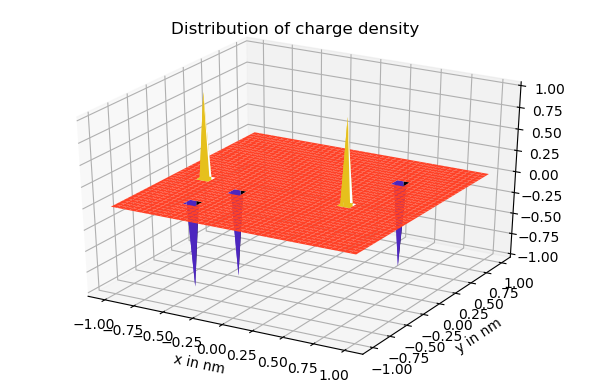

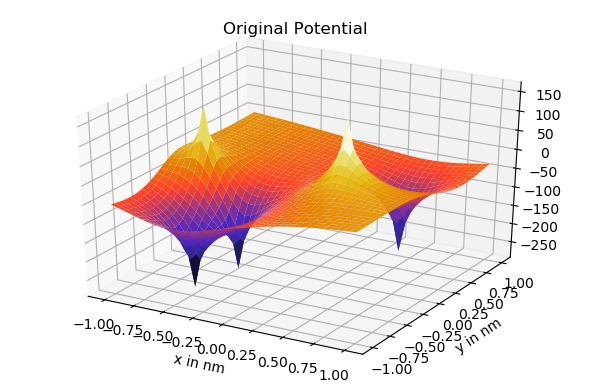

In [5]:
Nx = 40
Ny = 40
L = 1e-9
rho,Phi,x,y = Generate_rho(Nx, Ny, L, L, Seed=4)

fig1 = mpl.figure(dpi=100)
surf(x, y, rho, fig1)
mpl.title('Distribution of charge density')

fig2 = mpl.figure(dpi=100)
surf(x, y, Phi, fig2)
mpl.title('Original Potential')

mpl.show()

## Solve the Poisson Equation with Neumann Boundary Conditions

In an effort to solve the Poisson equation numerically,

$$ \Delta_{2D}\Phi(x,y) = -\dfrac{\rho}{\varepsilon_0} $$

we discretize the Laplace operator by an appoximation as

$$ \Delta_{2D} = \dfrac{1}{h^2}
\begin{bmatrix}
    \frac{1}{6} & \frac{2}{3} & \frac{1}{6} \\
    \frac{2}{3} & -\frac{10}{3} & \frac{2}{3} \\
    \frac{1}{6} & \frac{2}{3} & \frac{1}{6}
\end{bmatrix}
$$

Applying the charge density function $\rho(x,y)$ generated by `Generate_rho()` in the previouse section alone with the Neumann boundary conditions, the boundary value problem is formulated as a system of linear equations denoted by a sparse matrix, which will be solved by the sparse solver from scipy as follows.

In [82]:
# Transform the subscripts to indices
def sub2ind(arr_shape, rows, cols):
    # Note that Python is 0-based row-major indexing
    # ind = rows * arr_shape[1] + cols
    # but MATLAB is Fortan-style
    # ind = cols * arr_shape[1] + rows
    return np.ravel_multi_index((rows,cols), dims=arr_shape, order='F')

In [153]:
# Generate the Relation matrix of Laplace operator
def Poisson_create(rho, x_meshgr, y_meshgr):
    
    e = 1.6022e-19       # Elementarladung
    epsilon0 = 8.854e-12 # Vakuum Permittivität (Elektr. Feldkonstante) in As/Vm
    
    YX_shape = rho.shape
    Ny = rho.shape[0]
    Nx = rho.shape[1]
    N = Nx * Ny # Total number of points
    D = lil_matrix((N, N)) # Relation matrix of these N points
    dx = x_meshgr[0,1] - x_meshgr[0,0]
    dy = y_meshgr[1,0] - y_meshgr[0,0]
    h2 = dx * dy
    h = np.sqrt(h2)
    h3 = h**3
    
    
    """
    Go through all the points except the boundaries and create
    the linear equations (relation matrix) which represent the
    Laplace operator:
    """
    count = 0
    for ix in np.arange(2, Nx-2):
        for iy in np.arange(2, Ny-2):
            D[count, sub2ind(YX_shape, iy, ix)] = 10/3
            D[count, sub2ind(YX_shape, iy, ix+1)] = -2/3
            D[count, sub2ind(YX_shape, iy, ix-1)] = -2/3
            D[count, sub2ind(YX_shape, iy+1, ix)] = -2/3
            D[count, sub2ind(YX_shape, iy-1, ix)] = -2/3
            D[count, sub2ind(YX_shape, iy+1, ix+1)] = -1/6
            D[count, sub2ind(YX_shape, iy+1, ix-1)] = -1/6
            D[count, sub2ind(YX_shape, iy-1, ix+1)] = -1/6
            D[count, sub2ind(YX_shape, iy-1, ix-1)] = -1/6
            count = count + 1
    
    # Neumann boundary conditons
    for iy in np.arange(Ny):
        for ix in [0, Nx-1]: # First and last columns
            D[count, sub2ind(YX_shape, iy, ix)] = 1
            if ix == 0:
                D[count, sub2ind(YX_shape, iy, ix+1)] = -1
            if ix == Nx-1:
                D[count, sub2ind(YX_shape, iy, ix-1)] = -1
            count = count + 1
    
    for ix in np.arange(1, Nx-1):
        for iy in [0, Ny-1]: # First and last rows
            D[count, sub2ind(YX_shape, iy, ix)] = 1
            count = count + 1

    for iy in np.arange(1, Ny-1):
        for ix in [1, Nx-2]: # Columns inside the both edges
            D[count, sub2ind(YX_shape, iy, ix)] = -1
            count = count + 1
            
    for ix in np.arange(2, Nx-2):
        for iy in [1, Ny-2]: # Rows inside the both edges
            D[count, sub2ind(YX_shape, iy, ix)] = -1
            count = count + 1
    
    # Create the Poisson equation
    D = D.tocsr()
    Nshort = (Ny-4)*(Nx-4)
    b = np.zeros((N,1))
    b[0:Nshort] = np.reshape(rho[2:-2,2:-2], (Nshort,1)) *h2*e/(h3*epsilon0)
    
    return D, b

D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


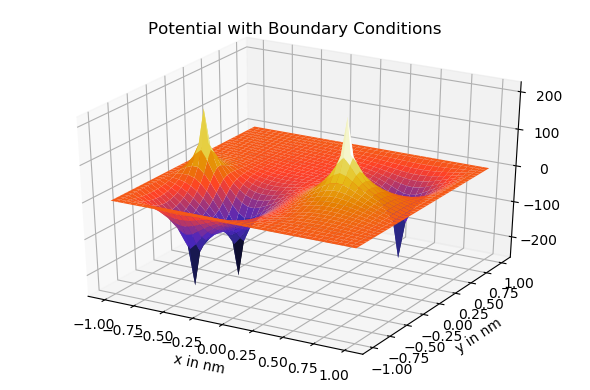

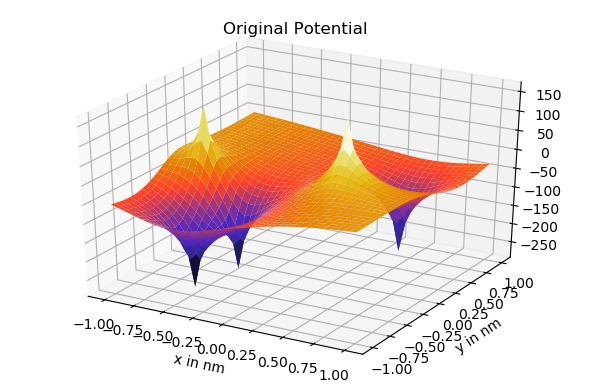

In [154]:
Nx = 40
Ny = 40
L = 1e-9

rho, Phi, x, y = Generate_rho(Nx, Ny, L, L, Seed=4)
D, b = Poisson_create(rho, x, y)
Phi2 = np.reshape(spsolve(D, b), (Ny, Nx))


fig3 = mpl.figure(dpi=100)
surf(x, y, Phi2, fig3)
mpl.title('Potential with Boundary Conditions')

fig4 = mpl.figure(dpi=100)
surf(x, y, Phi, fig4)
mpl.title('Original Potential')
mpl.show()

In [112]:
def JacobiIter(Phi0, max_iter=0, tol=1e-5):

    Ny, Nx = Phi0.shape
    if max_iter == 0:
        max_iter = 20*Nx*Ny
    w = 1.0
    
    # Hier definieren wir das Flag Feld, welches im Inneren 1 ist, und am Rand 0:
    flag = np.zeros((Ny,Nx)) # einhuellende Matrix mit Nullen
    flag[2:Ny-1,2:Nx-1] = 1 # innen Einsen
    phi = np.zeros((Ny,Nx)) # = phineu
    change = np.zeros((max_iter,))
    
    # Übertrage (skaliert) dessen Rand auf unser Problem.
    phi[flag == 0] = Phi0[flag == 0];
    phi0 = np.max(np.abs(Phi0));

    # Jacobi-Iterationen
    count   = 0
    for iter in range(max_iter):
        count += 1
        phialt = phi # fuer Jacobi-Verfahren
    
        phi = 0.25*(np.roll(phialt,1,axis=0)+np.roll(phialt,-1,axis=0)+np.roll(phialt,1,axis=1)+np.roll(phialt,-1,axis=1))
        phi[flag == 0] = Phi0[flag == 0]

        # Berechne Konvergenz:
        temp = np.sum(abs(phi-phialt)**2)

        # Überrelaxation:
        phi = phialt+w*(phi-phialt)
        w = 1+0.99*(w-1)
    
        phialt = phi;
        change[iter] = np.sqrt(temp/((Nx-2)*(Ny-2)-1)); # Standardabweichung
        if (iter > 2) & (w != 1):
            if change[iter] >= change[iter-1]:
                w = 1+0.5*(w-1);

        # print('Nach',iter,'Iterationen, Aenderung =',change[iter]);
        if( change[iter] < tol ):
            change = change[0:count]
            return phi,change
        
    return phi,change

## Comparing the Execution Time

In [127]:
t_LA = np.zeros(15)
t_JA = np.zeros(15)
Num = np.arange(10, 160, 10)

for i in np.arange(15):
    N = Num[i]
    L = 1e-9
    rho, Phi, x, y = Generate_rho(N, N, L, L, Seed=4)
    D, b = Poisson_create(rho, x, y)
    
    t0 = time.perf_counter()
    Phi_LA = np.reshape(spsolve(D, b), (N, N))
    t_LA[i] = time.perf_counter() - t0
    
    t1 = time.perf_counter()
    Phi_JA, change = JacobiIter(Phi, tol=1e-5)
    t_JA[i] = time.perf_counter() - t1

D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


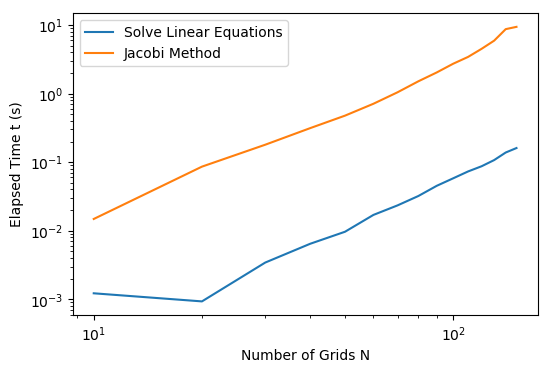

In [132]:
fig5 = mpl.figure(dpi=100)
mpl.plot(Num, t_LA, label='Solve Linear Equations')
mpl.plot(Num, t_JA, label='Jacobi Method')
mpl.xscale('log')
mpl.yscale('log')
mpl.xlabel('Number of Grids N')
mpl.ylabel('Elapsed Time t (s)')
mpl.legend(loc='best')
mpl.show()